# Perceval Quest
#### Author: *Valentin Deumier*

Our goal is to start by creating a 'classical' neural network and train it on the famous MNIST handwritten digits dataset, and then try to upgrade it by using Linear Optical Quantum Computing, in hope to increase the accuracy of the model and lower the duration of the calculations.

### <u>2: A hybrid model</u>

In [6]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from tqdm import tqdm
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model

import perceval as pcvl
import perceval.components as comp
from perceval.rendering.circuit import SymbSkin, PhysSkin
from perceval import Circuit

# Parameters
IMG_SIZE = 28
NUM_CLASSES = 10
BATCH_SIZE = 128
EPOCHS = 30

In [7]:
# Data into numpy arrays
def load_data(filename):

    data = pd.read_csv(filename)
    X = np.array(data['image'].str.split(',', expand=True).values)

    # Remove the [ ] from the image data (fastest method I found)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i, j] = X[i, j].replace('[', '').replace(']', '')
    X = X.astype(float)

    y = data['label'].values

    X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)/255.0      # Reshape and normalize
    y = to_categorical(y, NUM_CLASSES)
    return X, y

# Get the absolute path to the data folder
script_dir = os.getcwd()
data_dir = os.path.join(script_dir, 'data')

# Load the data
train_file = os.path.join(data_dir, 'train.csv')
X_train, y_train = load_data(train_file)
val_file = os.path.join(data_dir, 'val.csv')
X_val, y_val = load_data(val_file)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

# Divide the image resolution by 2 using max pooling
X_train = np.array(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(X_train))/255.0
X_val = np.array(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(X_val))/255.0

# X_train = np.array(tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(X_train))
# X_val = np.array(tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(X_val))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
EFF_IMG_SIZE = X_train.shape[1]


(6000, 28, 28, 1) (6000, 10) (600, 28, 28, 1) (600, 10)
(6000, 14, 14, 1) (6000, 10) (600, 14, 14, 1) (600, 10)


The idea here is to encode the image data into quantum data while preserving the 2-dimensional structure of the image. \
\
Like in the CNN model, we want neighbours pixels to remain close to each in the quantum representation so that we can perform "local" transformation (the equivalent of convoluting the image with a kernel), so the representation has to be continuous along both axis.\
This means that we can't flatten the data, so we can't use basis, angle or amplitude embedding.\
\
An idea could be to encode the image in a matrix representation of a unitary transformation (that could also be parametrized, and have its parameters be optimized).\
\
Being inspired by the solution of Schrodinger's equation for a time-independant Hamiltonian, we are going to represent the image $\mathbf{x}$ as the resulting evolution operator :

$$ U_t(\mathbf{x}) = \exp(-iH_{\mathbf{x}}t) $$

Where $H_{\mathbf{x}}$ is the symetric part of our image matrix:

$$ H_{\mathbf{x}} = \frac{\mathbf{x} + \mathbf{x}^T}{2} $$

with $t \in \mathbb{R}$ a parameter that we can tweak.

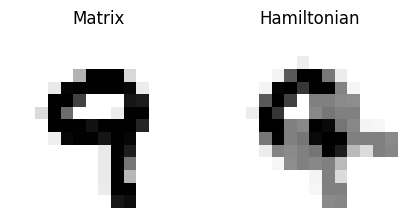

In [8]:
def toHamiltonian(x):
    H = 0.5*(x[:, :, 0] + x[:, :, 0].T)
    return H

def plot_hamiltonian(x):
    L = [x, toHamiltonian(x)]
    labels = ['Matrix', 'Hamiltonian']
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))
    for i in range(2):
        axes[i].imshow(L[i], cmap='gray_r')
        axes[i].set_title(labels[i])
        axes[i].axis('off')
    plt.show()

# Plot the first image and its Hamiltonian
plot_hamiltonian(X_train[1])

This exemple shows that almost half of the information contained in the input image is lost during the encoding process, as we only keep its symetrical part.

Another way of constructing a unitary matrix is by using the *unitary dilation theorem*:

Let $A \in \mathcal{M}_n(\mathbb{C})$ such that its spectral norm verifies $||A|| \le 1$, then

$$ U_A = \begin{bmatrix} A & \sqrt{\mathbb{I} - A A^\dagger} \\ \sqrt{\mathbb{I} - A^\dagger A} & -A^\dagger \end{bmatrix} $$

is a $2n \times 2n$ unitary matrix. 

Therefore, if we normalize our input image by its greatest eigenvalue, we can implement it as a 2n modes circuit. Since the whole image information is embedded in the upper half of $U_A$, we will consider a 2n modes circuit but we will effectively only work with the first n modes.

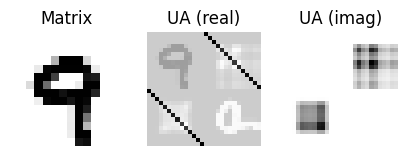

In [12]:
def U(x: np.ndarray, t: float) -> np.ndarray:
    """Compute the unitary operator associated with the Hamiltonian x and time t"""
    H = toHamiltonian(x)
    return linalg.expm(-1j*H*t)

def UA(x: np.ndarray) -> np.ndarray:
    """Compute the unitary operator using unitary dilation"""
    x = x[:, :, 0]
    x = x / np.linalg.eigvals(x).max()
    identity = np.eye(EFF_IMG_SIZE)
    B = np.block([
        [x, linalg.sqrtm(identity - x @ x.T)],
        [linalg.sqrtm(identity - x.T @ x), -x.T]
    ])
    return B

def plot_UA(x):
    L = [x, np.real(UA(x)), np.imag(UA(x))]
    labels = ['Matrix', 'UA (real)', 'UA (imag)']
    fig, axes = plt.subplots(1, 3, figsize=(5, 5))
    for i in range(3):
        axes[i].imshow(L[i], cmap='gray_r')
        axes[i].set_title(labels[i])
        axes[i].axis('off')
    plt.show()

plot_UA(X_train[1])

To reproduce the local effect of the convolution, the next layer will be constituted of a brickwork layout of beam splitters that are acting on modes close to each other.\
\
The operator associated with this layer will be denoted $V(\mathbf{\omega})$, with $\mathbf{\omega}$ being the array of parameters of the beam splitters.

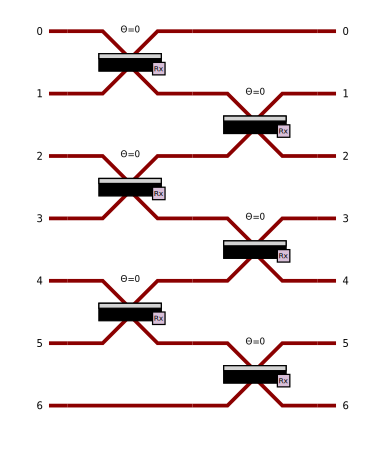

In [13]:
def brickwork(
    omega: np.ndarray,
    num_modes: int,
) -> Circuit:
    """
    Create a brickwork circuit with BS components.
    Args:   
        omega         : BS parameters (len(omega) = num_modes - 1)
        num_modes : Width of circuit
    Returns:
        Circuit
    """
    circ = Circuit(num_modes)
    even_modes = np.arange(0, num_modes - 1, 2)
    odd_modes = np.arange(1, num_modes - 1, 2)

    for k in even_modes:
        circ.add(int(k), comp.BS(omega[int(k)]))
    for j in odd_modes:
        circ.add(int(j), comp.BS(omega[int(j)]))
   
    return circ

# Example of a V(omega) layer
omega = np.zeros(6)
c2 = brickwork(omega, 7)
pcvl.pdisplay(c2)

# To do: Check if the model is better if we add phase shifters to the V layer

In [22]:
N = 7      # Number of photons
m = 7      # Number of modes   
L = 5       # Number of layers

# Input state with N photons and m modes
input_state = pcvl.BasicState([1]*N+[0]*(m-N))
print(input_state)

# Random parameters for the circuit initialization
t_params = np.random.uniform(0, 100, L)
omega_params = np.random.uniform(0, 2*np.pi, L*(m-1))

|1,1,1,1,1,1,1>


The code will follow the following scheme:
- Use the fonction **create_circuit(x, params)** that create the circuit with L layers $U_t(\mathbf{x}) V(\mathbf{\omega})$ associated to the image $\mathbf{x}$.
- Compute the full output probability with the input $N*|1>$.
- Convert the output into a predicted label
- Compute the sparse categorical cross-entropy loss (that is a function of $\mathbf{x}$ and the parameters)
- Do a minimization step.

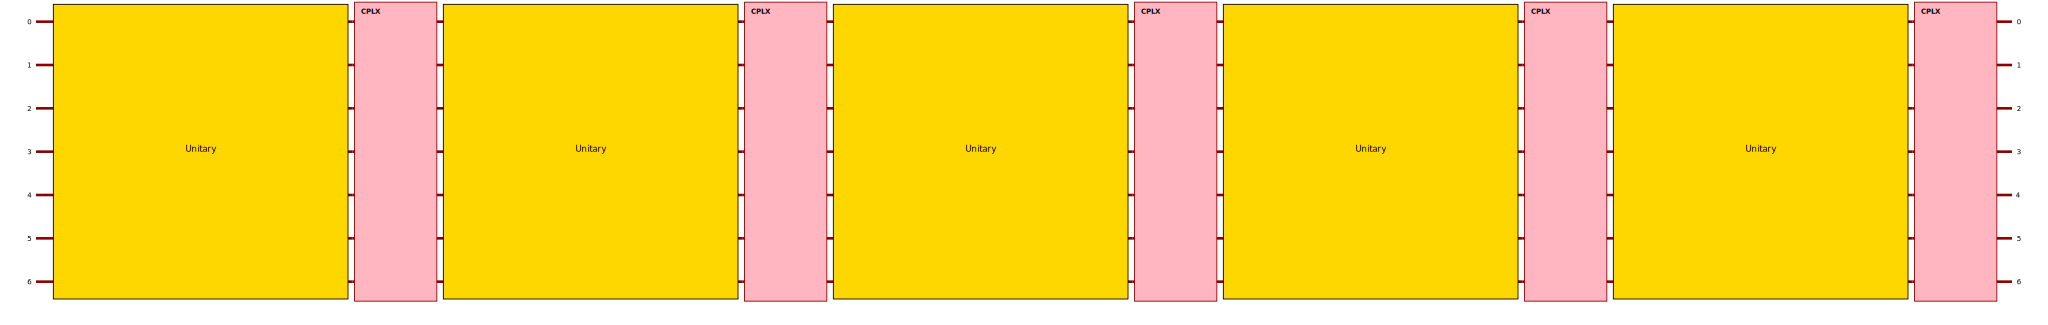

In [23]:
def create_circuit(x, t_params, omega_params):
    c = Circuit(m)
    for i in range(L):
        c.add(0, comp.Unitary(U=pcvl.Matrix(U(x, t_params[i]))))
        c.add(0, brickwork(omega_params[i*(m-1):(i+1)*(m-1)], m))
    return c

c = create_circuit(X_train[1], t_params, omega_params)
pcvl.pdisplay(c)

In [24]:
def compute_probabilities(x, t_params, omega_params):
    processor = pcvl.Processor("SLOS", create_circuit(x, t_params, omega_params))
    processor.with_input(input_state)
    sampler = pcvl.algorithm.Sampler(processor)
    prob_dist = sampler.probs()
    return prob_dist

# processor = pcvl.Processor("SLOS", create_circuit(X_train[2], t_params, omega_params))
# processor.with_input(input_state)

# sampler = pcvl.algorithm.Sampler(processor)
# prob_dist = sampler.probs()

# argmax = np.argmax(list(prob_dist['results'].values()))
# most_probable_output = list(prob_dist['results'].keys())[argmax]
# most_probable_probability = list(prob_dist['results'].values())[argmax]

# print("The most probable output is", most_probable_output, "with probability", most_probable_probability)

In [25]:
# Convert from the repartition of photon in the most probable output to a label
def output_to_label(output):
    return int(np.round(np.average(range(len(output)), weights=np.exp(output))*3/2))       # Scale the output to the range [0, 9]

def confidence_array(prob_dist):
    confidence = np.zeros(NUM_CLASSES)
    for output, prob in prob_dist['results'].items():
        label = output_to_label(output)
        confidence[label] += prob
    return confidence

# print(output_to_label(most_probable_output))

In [26]:
def sparse_categorical_crossentropy(y_true, y_pred):
    return -np.log(y_pred[y_true])

def sparse_categorical_accuracy(y_true, y_pred):
    return np.argmax(y_pred) == y_true

def model_accuracy(X, y, t_params, omega_params):
    accuracy = 0
    for i in range(X.shape[0]):
        prob_dist = compute_probabilities(X[i], t_params, omega_params)
        confidence = confidence_array(prob_dist)
        y_pred = np.argmax(confidence)
        y_true = np.argmax(y[i])
        accuracy += sparse_categorical_accuracy(y_true, confidence)
    return accuracy/X.shape[0]


In [27]:
def minimize_step(x, y_true, t_params, omega_params, learning_rate=0.01):
    # Compute the probabilities
    prob_dist = compute_probabilities(x, t_params, omega_params)
    y_pred = confidence_array(prob_dist)
    
    # Compute the loss
    loss = sparse_categorical_crossentropy(np.argmax(y_true), y_pred)
    
    # Compute the gradients (numerical gradient approximation)
    grad_t_params = np.zeros_like(t_params)
    grad_omega_params = np.zeros_like(omega_params)
    
    epsilon = 1e-5
    for i in range(len(t_params)):
        t_params[i] += epsilon
        prob_dist = compute_probabilities(x, t_params, omega_params)
        y_pred = confidence_array(prob_dist)
        loss_plus = sparse_categorical_crossentropy(np.argmax(y_true), y_pred)
        
        grad_t_params[i] = (loss_plus - loss) / epsilon
        t_params[i] -= epsilon
    
    for i in range(len(omega_params)):
        omega_params[i] += epsilon
        prob_dist = compute_probabilities(x, t_params, omega_params)
        y_pred = confidence_array(prob_dist)
        loss_plus = sparse_categorical_crossentropy(np.argmax(y_true), y_pred)
        
        grad_omega_params[i] = (loss_plus - loss) / epsilon
        omega_params[i] -= epsilon
    
    # Update the parameters
    t_params -= learning_rate * grad_t_params
    omega_params -= learning_rate * grad_omega_params
    
    return t_params, omega_params, loss

# Example usage
x = X_train[0]
y_true = y_train[0]
t_params, omega_params, loss = minimize_step(x, y_true, t_params, omega_params)
print("Updated t_params:", t_params)
print("Updated omega_params:", omega_params)
print("Loss:", loss)

Updated t_params: [85.59587425 71.76490126 62.47481577 75.02385497 35.97334965]
Updated omega_params: [4.78194771 1.83819531 1.49357521 5.13284721 2.74013361 3.5715839
 1.81107495 0.22548475 1.69902984 5.13933282 3.82855878 4.48161959
 0.57647882 2.23618921 4.09755847 5.80799862 0.18382106 3.86922377
 1.64029257 5.61460955 0.16882566 2.67724135 1.63497052 2.39213942
 0.45926031 4.78339048 1.77962776 0.60335195 2.09930755 4.63776232]
Loss: 1.797839152220595


In [29]:
# Training loop

def train(X_train, y_train, X_val, y_val, t_params, omega_params, learning_rate=0.01, epochs=1):
    for epoch in range(epochs):
        print("Epoch", epoch)
        for i in tqdm(range(len(X_train)), desc="Training"):
            x = X_train[i]
            y_true = y_train[i]
            t_params, omega_params, loss = minimize_step(x, y_true, t_params, omega_params, learning_rate)
            if i % 100 == 0:
                print("Loss:", loss)
        print("Validation accuracy:", model_accuracy(X_val, y_val, t_params, omega_params))
    return t_params, omega_params

t_params, omega_params = train(X_train, y_train, X_val, y_val, t_params, omega_params, learning_rate=0.01, epochs=1)

Epoch 0


Training:   0%|          | 1/6000 [00:08<14:13:36,  8.54s/it]

Loss: 1.7963455742298455


Training:   2%|▏         | 101/6000 [15:00<15:13:21,  9.29s/it]

Loss: 1.547817214898068


Training:   3%|▎         | 176/6000 [26:53<14:49:51,  9.17s/it]


KeyboardInterrupt: 